## Failed, signal too weak
candle bar is purely noise at lower timeframe with no arbitrage available at all

In [ ]:

from operator import mul
from functools import reduce
import copy
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
from typing import List


def plot_bars(time_bar: pd.DataFrame, vrun_bar: pd.DataFrame):
    import plotly.graph_objects as go
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=time_bar['time'], y=time_bar['close'], mode='lines', name='Time bar'))
    fig.add_trace(go.Scatter(x=vrun_bar['time'], y=vrun_bar['high'], line=dict(width=0), mode='lines', showlegend=False, hoverinfo='skip'))
    fig.add_trace(go.Scatter(x=vrun_bar['time'], y=vrun_bar['low'], fill='tonexty', fillcolor='rgba(200, 200, 200, 0.5)', line=dict(width=0), mode='lines', name='High-Low Range', hoverinfo='skip'))
    fig.add_trace(go.Scatter(x=vrun_bar['time'], y=vrun_bar['close'], mode='lines+markers', marker=dict(color=vrun_bar['label_discrete'], colorscale='RdBu', showscale=True, size=10), name="data",))
    fig.add_trace(go.Scatter(x=vrun_bar['time'], y=vrun_bar['close']-3000, mode='lines+markers', marker=dict(color=vrun_bar['label_uniqueness'], colorscale='Plasma'), name="data"))
    fig.update_layout(xaxis=dict(type='category'))
    fig.show()


def plot_line(df: pd.DataFrame, support: str, field: str, color: str):
    import plotly.graph_objects as go
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df[support], y=df[field], mode='lines+markers', marker=dict(color=df[color], colorscale='RdBu', showscale=True, size=10), name="data",))
    fig.update_layout(xaxis=dict(type='category'))
    fig.show()


def plot_3D(df: pd.DataFrame, fields: List[str | int], color: str | int):
    import plotly.graph_objects as go
    fig = go.Figure()
    fig = go.Figure(data=[go.Scatter3d(
        x=df[fields[0]],
        y=df[fields[1]],
        z=df[fields[2]],
        mode='markers',  # or 'lines+markers' or 'lines'
        marker=dict(
            size=5,
            color=df[color],  # Optional: use z as color
            colorscale='RdBu',
            opacity=0.8
        )
    )])
    fig.show()


def plot_density(df: pd.DataFrame, field: str | int):
    from scipy.stats import gaussian_kde
    import plotly.graph_objects as go
    x = df[field]
    kde = gaussian_kde(x)
    x_vals = np.linspace(x.min(), x.max(), 1000)
    y_vals = kde(x_vals)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_vals, y=y_vals, mode='lines', name='KDE'))
    fig.update_layout(title='KDE of label', xaxis_title='Label', yaxis_title='Density')
    fig.show()


def plot_umap_3D(X: pd.DataFrame, y: pd.Series):
    import umap
    import plotly.graph_objects as go
    import plotly.express as px
    import numpy as np

    n_neighbors = min(15, X.shape[0] - 1)

    algo_umap = umap.UMAP(n_components=3, n_neighbors=n_neighbors, min_dist=0.1)
    X_3d = np.array(algo_umap.fit_transform(X))

    classes = np.sort(np.unique(y))[::-1]  # sort from large(red) to small(blue)
    print(f'Classes: {classes}')

    # RdBu continuous colorscale
    colorscale = px.colors.diverging.RdBu
    n_colors = len(colorscale)

    fig = go.Figure()

    for i, cls in enumerate(classes):
        idx = y == cls
        # Map class index to a color in RdBu colorscale
        color_idx = int(i / (len(classes) - 1) * (n_colors - 1)) if len(classes) > 1 else 0
        color = colorscale[color_idx]

        fig.add_trace(go.Scatter3d(
            x=X_3d[idx, 0], y=X_3d[idx, 1], z=X_3d[idx, 2],
            mode='markers',
            name=f'Class {cls}',
            marker=dict(
                size=4,
                color=color,
                opacity=1.0,
            )
        ))

    fig.show()


def plot_pca_3D(X: pd.DataFrame, y: pd.Series):
    from sklearn.decomposition import PCA
    import plotly.graph_objects as go
    import plotly.express as px
    import numpy as np

    # Fit PCA with 3 components
    pca = PCA(n_components=3)
    X_3d = pca.fit_transform(X)

    classes = np.sort(np.unique(y))[::-1]  # sort from large (red) to small (blue)
    print(f'Classes: {classes}')

    # RdBu continuous colorscale
    colorscale = px.colors.diverging.RdBu
    n_colors = len(colorscale)

    fig = go.Figure()

    for i, cls in enumerate(classes):
        idx = y == cls
        # Map class index to a color in RdBu colorscale
        color_idx = int(i / (len(classes) - 1) * (n_colors - 1)) if len(classes) > 1 else 0
        color = colorscale[color_idx]

        fig.add_trace(go.Scatter3d(
            x=X_3d[idx, 0], y=X_3d[idx, 1], z=X_3d[idx, 2],
            mode='markers',
            name=f'Class {cls}',
            marker=dict(
                size=4,
                color=color,
                opacity=1.0,
            )
        ))

    fig.update_layout(
        scene=dict(
            xaxis_title="PC1",
            yaxis_title="PC2",
            zaxis_title="PC3"
        ),
        title="3D PCA Projection"
    )

    fig.show()


class OnlineEMA:
    def __init__(self, window_size: int):
        self.alpha = 2 / (window_size + 1)  # smoothing factor
        self.ema = None  # use None to check for initialization

    def update(self, x: float):
        if self.ema is None:
            self.ema = x  # first value
        else:
            self.ema = self.alpha * x + (1 - self.alpha) * self.ema

    def mean_value(self) -> float:
        return self.ema if self.ema is not None else 0.0


class OnlineMean:
    # Cumulative Moving Average
    def __init__(self):
        self.n = 0
        self.mean = 0.0

    def update(self, x):
        self.n += 1
        self.mean += (x - self.mean) / self.n

    def mean_value(self):
        return self.mean


class OnlineMeanVariance:
    # Welford_algorithm
    def __init__(self):
        self.n = 0
        self.mean = 0.0
        self.M2 = 0.0  # This is M_n

    def update(self, x):
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2

    def variance(self):
        if self.n <= 1:
            return 0.0
        else:
            return self.M2 / (self.n - 1)  # sample variance

    def mean_value(self):
        return self.mean


class FastLookupTable:
    def __init__(self, dim_per_layer, init_value=None):
        """
        dim_per_layer: list[int]
        init_value: the value to deep-copy into each cell (e.g., a list or dict)
        """
        self.dims = dim_per_layer
        self.ndim = len(dim_per_layer)
        self.size = reduce(mul, self.dims)
        self.init_value = init_value

        # Precompute flat index multipliers
        self.multipliers = [1] * self.ndim
        for i in range(self.ndim - 2, -1, -1):
            self.multipliers[i] = self.multipliers[i + 1] * self.dims[i + 1]

        # Fill each slot with a deep copy of init_value
        self.table = [copy.deepcopy(init_value) for _ in range(self.size)]

    def encode_index(self, indices):
        return sum(i * m for i, m in zip(indices, self.multipliers))

    def decode_index(self, index):
        result = []
        for d in reversed(self.dims):
            result.append(index % d)
            index //= d
        return list(reversed(result))

    def set(self, indices, value):
        self.table[self.encode_index(indices)] = value

    def get(self, indices):
        return self.table[self.encode_index(indices)]

    def __getitem__(self, indices):
        return self.get(indices)

    def __setitem__(self, indices, value):
        self.set(indices, value)

    def __len__(self):
        return self.size

    def __iter__(self):
        for flat_idx in range(self.size):
            multi_idx = self.decode_index(flat_idx)
            yield multi_idx, self.table[flat_idx]

# dir = os.getcwd()
dir = os.path.dirname(__file__)


def main():
    data_path = os.path.join(dir, "data/bars.parquet")

    time_bar_dtype = {
        'time': 'int64',
        'open': 'float32',
        'high': 'float32',
        'low': 'float32',
        'close': 'float32',
        'volume': 'float32',
    }

    run_bar_dtype = {
        'time': 'int64',
        'timedelta': 'int32',
        'open': 'float32',
        'high': 'float32',
        'low': 'float32',
        'close': 'float32',
        'vwap': 'float32',
        'threshold': 'float32',
        'label_continuous': 'float32',
        'label_discrete': 'int32',
        'label_uniqueness': 'float32',
        'umap_x': 'float32',
        'umap_y': 'float32',
        'umap_z': 'float32',
    }

    input_dtype = np.dtype([(k, v) for k, v in time_bar_dtype.items()])
    output_dtype = np.dtype([(k, v) for k, v in run_bar_dtype.items()])

    time_bar = pd.read_parquet(data_path).reset_index(drop=True)
    input_array = time_bar.to_records(index=False).astype(input_dtype)
    input_bytes = input_array.tobytes()

    print(time_bar)
    print("Num bars:", input_array.shape[0])
    print("Bytes per record:", input_array.dtype.itemsize)

    from cpp import Pipeline  # type: ignore
    try:
        output_bytes = Pipeline.process_bars(input_bytes, input_array.shape[0])
    except Exception as e:
        import traceback
        traceback.print_exc()
        print("Caught exception:", str(e))

    vrun_bar = pd.DataFrame(np.frombuffer(output_bytes, dtype=output_dtype))
    vrun_bar['return'] = np.log1p(vrun_bar['close'].pct_change().fillna(0))
    print(vrun_bar)

    from collections import deque
    num_obvs = 3
    num_preds = 2
    num_volume_search = 2  # find which of the recent N bars has large volume, as a feature
    assert num_obvs > num_preds
    assert num_preds >= num_volume_search
    # samples: vrun_bar.shape[0]
    # column:     0,           1, ...             4,           5,               6,     8,      9,     10,
    # (high1>high0), (low1>low0), ... (high3>high2), (low3>low2), min_delta_index, label1, label2, label3,
    # min_delta_index: this is to identify which bar has biggest volume (avoid adding more feature because overfitting)
    # label: total_return, profit_factor, martin_ratio
    #  I  I  I  I  I  I  I
    # |   OBV     | LABEL |

    buffer_h = deque(maxlen=num_obvs)
    buffer_l = deque(maxlen=num_obvs)
    buffer_r = deque(maxlen=num_obvs)
    buffer_t = deque(maxlen=num_obvs)
    buffer_idx = deque(maxlen=num_preds+1)
    # history = np.zeros((vrun_bar.shape[0], 2*(num_obvs-1)+2+num_preds), dtype=float)
    table = FastLookupTable(dim_per_layer=[2]*(num_obvs-1)+[num_obvs-1]*2, init_value=[OnlineMean(), OnlineMean()])  # [label_mean, label_accuracy] * N

    global_count = OnlineEMA(200)
    f_candles = []

    for idx, row in tqdm(enumerate(vrun_bar.itertuples(index=False))):
        high = float(row.high)  # type: ignore
        low = float(row.low)  # type: ignore
        timedelta = int(row.timedelta)  # type: ignore

        # Calculate returns (skip first bar)
        if idx > 0:
            buffer_r.append(((high + low) / (buffer_h[-1] + buffer_l[-1]) - 1) * 100)
        else:
            buffer_r.append(0.0)
        buffer_h.append(high)
        buffer_l.append(low)
        buffer_t.append(timedelta)

        # Calculate features once buffer is full
        if idx >= num_obvs:
            features = []
            for j in range(num_obvs - 1):
                features.append(int(buffer_h[j + 1] > buffer_h[j]))
                features.append(int(buffer_l[j + 1] > buffer_l[j]))
            features.append(int(np.argmin(list(buffer_t)[-num_volume_search:])))  # Bar with smallest timedelta in last few bars

            buffer_idx.append(tuple(features))

        # Calculate labels after sufficient future data
        if idx >= num_obvs + num_preds:
            # Get returns for next j+1 bars (strictly future)
            start_idx = num_obvs - num_preds
            rets = list(buffer_r)[start_idx:]
            # pos_sum = sum(r for r in rets if r > 0)
            # neg_sum = sum(r for r in rets if r < 0)
            # label = abs(pos_sum / neg_sum) if neg_sum != 0 else 100.0
            label = sum(rets)

            # Update statistics
            label_mean = table[buffer_idx[0]][0]  # type: ignore
            label_mean.update(label)
            pat_count = label_mean.n
            pat_prediction = label_mean.mean_value()
            
            label_accuracy = table[buffer_idx[0]][1]  # type: ignore
            label_accuracy.update(int((pat_prediction > 0) == (label > 0))) # prediction align with actual results
            pat_accuracy = label_accuracy.mean_value()

            global_count.update(pat_count)
            
            valid = 1
            valid &= pat_accuracy > 0.57  # (label_accuracy_ema.mean_value()+0.01)  # check prediction accuracy
            valid &= pat_count > global_count.mean_value()*0.2

            # print(valid_count&valid_variance, count, label_count_mean.mean, variance, label_variance_mean.mean)

            # Store prediction
            if valid:
                f_candles.append(pat_prediction)
            else:
                f_candles.append(0.0)

    vals = []
    for idx, struct in table:
        val0 = struct[1].mean
        val1 = struct[1].n
        if val0 != 0:
            vals.append((val0,val1))

    print(vals)
    from scipy.stats import gaussian_kde
    import plotly.graph_objects as go
    x = [x[0] for x in vals]
    kde = gaussian_kde(x)
    x_vals = np.linspace(min(x), max(x), 1000)
    y_vals = kde(x_vals)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_vals, y=y_vals, mode='lines', name='KDE'))
    fig.update_layout(title='KDE of label', xaxis_title='Label', yaxis_title='Density')
    fig.show()

    limit = 50000
    df = vrun_bar[-limit:]
    support = 'time'
    field = 'close'
    import plotly.graph_objects as go
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df[support], y=df[field]-0000, mode='lines+markers', marker=dict(color=f_candles[-limit:], colorscale='RdBu', showscale=True, size=10), name="data",))
    fig.update_layout(xaxis=dict(type='category'))
    fig.show()

    # print(f_candles)
    assert False
    # Tail softening: clamp label values to 25%-75% range
    for j in range(num_preds):
        label_col = history[:, 3*(num_obvs-1)+j]
        q25, q75 = np.percentile(label_col, 25), np.percentile(label_col, 75)
        label_col = np.clip(label_col, q25, q75)
        history[:, 3*(num_obvs-1)+j] = label_col

    # Rounding as classifications
    label1 = history[:, 3*(num_obvs-1)]
    round_unit = (max(label1) - min(label1)) / 10
    round_coef = int(1/round_unit)
    for j in range(num_preds):
        history[:, 3*(num_obvs-1)+j] = np.round(history[:, 3*(num_obvs-1)+j] * round_coef) / round_coef

    history = pd.DataFrame(history)
    print(history.describe())

    limit = 10000
    X = history.iloc[:, :3*(num_obvs-1)][-limit:-10]
    y = history.iloc[:, 3*(num_obvs-1)+0][-limit:-10]
    # plot_umap_3D(X, y)
    plot_pca_3D(X, y)
    # plot_3D(stats, [0, 1, 2], idx_weighted)

    # plot_line(vrun_bar, 'time', 'close', 'label_discrete')
    # plot_density(vrun_bar, 'label_continuous')
    # plot_density(vrun_bar, 'return')
    # plot_3D(vrun_bar, ['umap_x', 'umap_y', 'umap_z'], 'label_discrete')


if __name__ == "__main__":
    main()


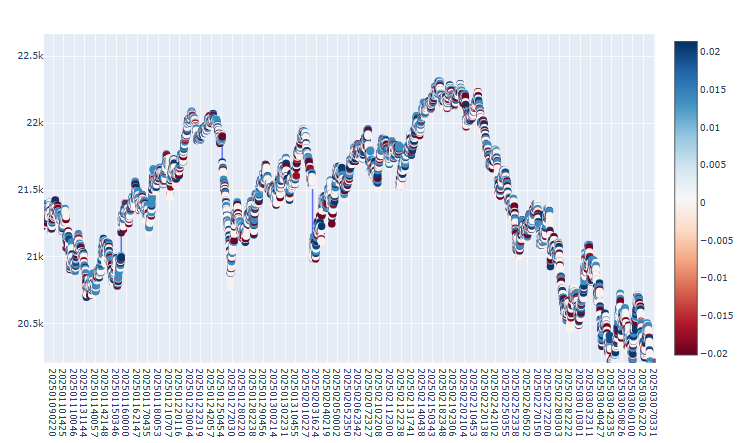

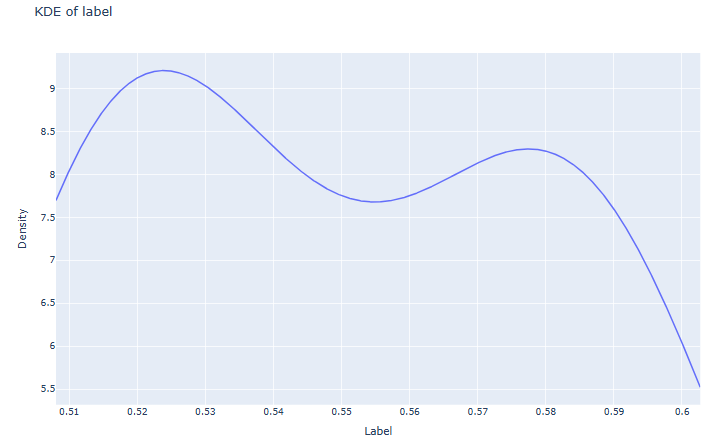